## Load needed libraries 

In [32]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [35]:
# Load all the caption 
def load_doc(filepath):
    # open the file as read only
    file = open(filepath, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    
    return text

filepath = "Flickr8k/Flickr8k_text/Flickr8k.token.txt"

doc = load_doc(filepath)
doc
# Exam the first 400 characters
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [36]:
# For each image, we have 5 captions. So we gonna save all the caption in a dictionary in format:
# id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']

def load_descriptions(doc):
    mapping = dict()
    # go through each line
    for line in doc.split('\n'):
        # split words by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        
        # add image_id as key and create the list for holding captions
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Images Loaded: %d ' % len(descriptions))

Images Loaded: 8092 


In [41]:
# Looking at some caption of images
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

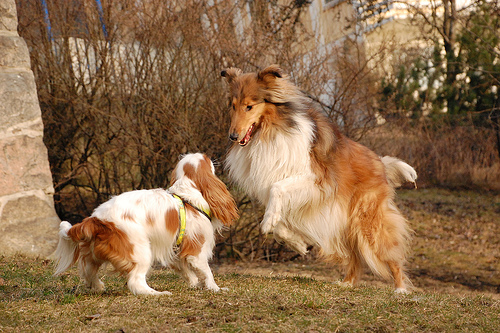

collie and springer spaniel playing outside
the large brown and white dog is jumping towards the small brown and white dog
two brown and white dogs fighting on grassy area in front of tree
two brown and white dogs in the grass near stone structure
two tan and white dogs look at each other in an outdoor setting


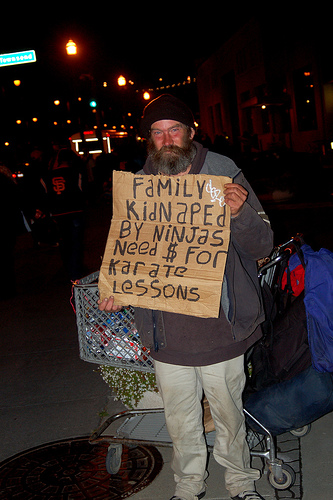

bearded man is standing by shopping cart holding up cardboard sign
guy holding sign with shopping cart
homeless man holding sign written on cardboard
man holds sign seeking money
homeless man begging for money using humorous sign


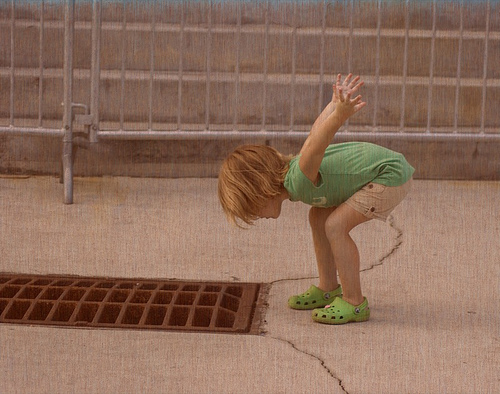

child in green shoes staring down drain
young child in green shirt and crocks looking down drain
blond girl looking down the grating on the road
the little girl in green bends down the check out the drainpipe
the small child in green crocks leans over to look inside grate


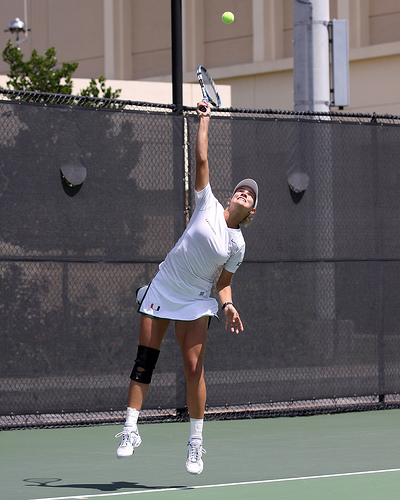

female tennis player hitting the ball
woman in white tennis outfit has jumped into the air to hit tennis ball
woman in white tennis outfit is jumping up to hit the ball
woman wearing white jumps up to hit the ball during tennis match
woman wearing white reaches high above herself to hit tennis ball


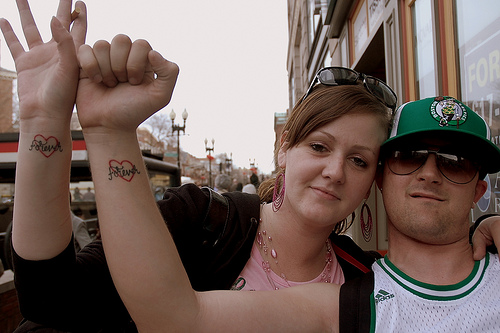

girl with cigarette in hand and guy with green hat wave at the camera
man and woman show their tatooed hearts on their wrists
man and woman hug
man in green celtics hat and woman wearing black sweater display identical tattoos on their right wrists
there is man and woman holding up their arms and showing their heart tattoos


In [43]:
def display_random_data(count=5, seed=42):
    np.random.seed(seed)
    # random choose number of images == count
    images = np.random.choice(list(descriptions), count)    
    # display and their captions
    for image in images:
        # display image
        display(Image.open(f'Flickr8k/Flicker8k_Dataset/{image}.jpg'))
        # display caption
        img_captions = descriptions[image]
        for caption in img_captions:
            print(caption)
display_random_data()

## Prepare data for training
- Preprocessing the caption:  
  + Convert to lowercase
  + Remove special character
  + Remove word with numbers (e.g. hey199)
  + Add start and ending token
- Preprocessing the images:
  + Resize images to fit into pre-trained model (e.g. VGG16, ResNet,etc) in order to extract features 

In [40]:
# Preprocessing text
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    
    for image_id, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [42]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [44]:
# Save descriptions.txt
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [47]:
# Take the id corresponding with train, test and dev set
def load_dataset(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get only the id of image and rid of '.jpg'
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
train_filename = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# load testing dataset (1K)
test_filename = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# load validate dataset (1K)
dev_filename = 'Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'

train_id = load_dataset(train_filename)
test_id = load_dataset(test_filename)
validate_id = load_dataset(dev_filename)

print('Train set: %d' % len(train_id))
print('Test set: %d' % len(test_id))
print('Validate set: %d' % len(validate_id))

Train set: 6000
Test set: 1000
Validate set: 1000


In [51]:
# Images directory
img_dir = 'Flickr8k/Flicker8k_Dataset/'
# Save all the images path
imgs_path = glob.glob(img_dir + '*.jpg')

In [56]:
# File contains train id images
train_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in imgs_path:
    if i[len(img_dir):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [57]:
# File contains test id images
test_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in imgs_path:
    if i[len(img_dir):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [61]:
# File contains valdiate id images
val_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
# Read the test image names in a set
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
val_img = []

for i in imgs_path: 
    if i[len(img_dir):] in val_images: # Check if the image belongs to test set
        val_img.append(i) # Add it to the list of test images

In [64]:
# Adding token 'startseq', 'endseq' 
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list to contain captions
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# Loop through all the images in the descriptions but take only the images in train set
train_descriptions = load_clean_descriptions('descriptions.txt', train_id)
print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 6000
